In [1]:
import sys
import torch
sys.path.append('..')
sys.path.append('../..')
from env_arm import ArmEnv
from trimesh import Trimesh
import trimesh
import numpy as np
import meshio
import matplotlib.pyplot as plt
from collections import OrderedDict
from mikmarkermatch import init_realdata, init_simenv, align_sim_real


plt.rcParams.update({'font.size': 7, 'pdf.fonttype': 42, 'ps.fonttype': 42})
mm = 1/25.4
plt.rcParams.update({'figure.figsize': (88*mm, 60*mm)})

/opt/anaconda3/envs/residual-phy/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
arm_folder = "arm_measure_test_sep_4"
# model = '../sopra_model/Segment.vtk'
# model = '../sopra_model/sopra_test3.vtk'
model = '../sopra_model/sopra_494.vtk'
sopra_env, method, opt = init_simenv(model, arm_folder)
sopra_env._dofs

../sopra_model/sopra_494.vtk


1482

In [3]:
np.where((sopra_env.outer_faces == 458).any(axis=1))

(array([284, 407, 462, 468]),)

In [4]:
dt = 0.01

In [5]:
real_p, base_q = init_realdata("../arm_data_sep_4/captured_data_singleChamberCalibration.npy")

In [6]:
mikmarkers = np.array([
[-62.9, -23, -8.2], #0
[-62.9, 22, -8.2], #1
[31.3, -21.6, -8.2], #2
[18, -17, -128], #3
[21, 9, -128], #4
[-8, 21, -128], #5
[-21, 10, -128], #6
[-20, -20, -128], #7
[18, 10, -146], #8
[-26, 8, -146], #9
[-3, -29, -146], #10
[11, -10, -266], #11
[-6, 14, -266], #12
[-21, -10, -266], #13
[-8, -20, -266], #14
]) * 1e-3 + np.array([0, 0, 2.92047]) * 1e-3
# mikmarkers[:, 1] *= -1
mikmarkers = mikmarkers[[1, 2, 0, 4, 3, 6, 5, 7, 8, 9, 10, 12, 11, 14, 13]]

In [7]:
steady_state = base_q[0,0]

In [8]:
sopra_env.set_target_points(mikmarkers)
R, t = sopra_env.fit_realframe(steady_state)
real_markers = steady_state @ R.T + t
error = np.linalg.norm(real_markers[3:] - mikmarkers[3:])/np.linalg.norm(real_markers[3:])
error

0.01686012393135723

In [9]:
transformed_markers = base_q[:, :, 3:] @ R.T + t

In [16]:
sopra_env.compute_interpolation_coeff(real_markers[3:])

In [17]:
transformed_markers.shape

(6, 500, 12, 3)

In [18]:
q = torch.from_numpy(sopra_env._q0)
for frame_i in range(1):
    f_ext = sopra_env.apply_inner_pressure(real_p[1],q.detach().numpy(), chambers=[1])

In [ ]:
qs_chambers = []
errors = []
for i in range(6):
    q = torch.from_numpy(sopra_env._q0)
    v = torch.zeros_like(q)
    error_chamber = []
    frame_i = 0
    simulated_markers = sopra_env.return_simulated_markers(q.reshape(-1, 3))
    sopra_env.vis_dynamic_sim2real_markers(f"chamber_{i}_dofs_{sopra_env._dofs}", q.detach().numpy(),simulated_markers,transformed_markers[i, frame_i] ,frame=0)
    qs = []
    qs.append(q.detach().numpy())
    error_chamber.append(np.linalg.norm(simulated_markers - transformed_markers[i, frame_i]))
    for frame_i in range(1, transformed_markers.shape[1]):
        f_ext = sopra_env.apply_inner_pressure(real_p[i], q.detach().numpy(), chambers=[i])
        f_ext = torch.from_numpy(f_ext)
        try:
            q,v = sopra_env.forward(q, v, f_ext=f_ext, dt=dt)
        except:
            break
        q_reshape = q.reshape(-1, 3)
        simulated_markers = sopra_env.return_simulated_markers(q_reshape)
        sopra_env.vis_dynamic_sim2real_markers(f"chamber_{i}_dofs_{sopra_env._dofs}", q.detach().numpy(), simulated_markers, transformed_markers[i, frame_i], frame=frame_i)
        error_chamber.append(np.linalg.norm(simulated_markers - transformed_markers[i, frame_i]))
        qs.append(q.detach().numpy())
    qs_chambers.append(qs)
    errors.append(error_chamber)
np.save(f"qs_chambers_{sopra_env._dofs}.npy", qs_chambers)

In [13]:
np.save(f"error_chamber_{sopra_env._dofs}.npy", errors)

NameError: name 'errors' is not defined

In [27]:
qs_chambers = np.load(f"qs_chambers_{sopra_env._dofs}.npy")

In [29]:
transformed_markers = base_q[:, :, 3:] @ R.T + t
transformed_markers.shape
steady_real_markers = transformed_markers[0,0]
outer_faces_nodes = np.unique(sopra_env.outer_faces)
outer_faces_vertices = sopra_env._vertices[outer_faces_nodes]
closest_nodes = []
frame_i = 0
for i, target_point in enumerate(steady_real_markers):
    closest_node = np.argmin(np.linalg.norm(outer_faces_vertices - target_point, axis=1))
    closest_nodes.append(sopra_env._vertices[outer_faces_nodes[closest_node]])
closest_nodes = np.array(closest_nodes)
# sopra_env.vis_dynamic_sim2real_markers(f"test", sopra_env._q0, closest_nodes, steady_real_markers, frame=frame_i)#transformed_markers[frame_i], frame=frame_i)

q_reshape = torch.from_numpy(sopra_env._q0.reshape(-1, 3))
simulated_markers = sopra_env.return_simulated_markers(q_reshape)
sopra_env.vis_dynamic_sim2real_markers(f"test", sopra_env._q0, simulated_markers, steady_real_markers, frame=10)#transformed_markers[frame_i], frame=frame_i)

In [30]:
simulated_markers, steady_real_markers

(tensor([[ 0.0212,  0.0096, -0.1256],
         [ 0.0163, -0.0188, -0.1240],
         [-0.0235,  0.0134, -0.1227],
         [-0.0083,  0.0229, -0.1244],
         [-0.0217, -0.0186, -0.1225],
         [ 0.0205,  0.0099, -0.1437],
         [-0.0258,  0.0125, -0.1426],
         [-0.0032, -0.0298, -0.1426],
         [-0.0070,  0.0164, -0.2647],
         [ 0.0133, -0.0104, -0.2653],
         [-0.0073, -0.0220, -0.2644],
         [-0.0208, -0.0143, -0.2640]], dtype=torch.float64),
 array([[ 0.021,  0.01 , -0.126],
        [ 0.016, -0.019, -0.124],
        [-0.024,  0.013, -0.123],
        [-0.008,  0.023, -0.124],
        [-0.022, -0.019, -0.122],
        [ 0.021,  0.01 , -0.144],
        [-0.026,  0.012, -0.143],
        [-0.003, -0.03 , -0.143],
        [-0.007,  0.016, -0.265],
        [ 0.013, -0.01 , -0.265],
        [-0.007, -0.022, -0.264],
        [-0.021, -0.014, -0.264]]))

In [31]:
error = np.linalg.norm(simulated_markers - steady_real_markers)/np.linalg.norm(steady_real_markers)
error

1.0231189380160327e-16

In [32]:
closest_triangles = sopra_env._vertices[np.array(sopra_env.attached_tri)].reshape(-1, 3)

In [33]:
sopra_env.vis_dynamic_sim2real_markers(f"test", sopra_env._q0, closest_triangles, steady_real_markers, frame=3)#transformed_markers[frame_i], frame=frame_i)

[-0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004
 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004
 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004
 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004
 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004
 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004
 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004
 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004
 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004
 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004
 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004
 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004
 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004
 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004 -0.004
 -0.00

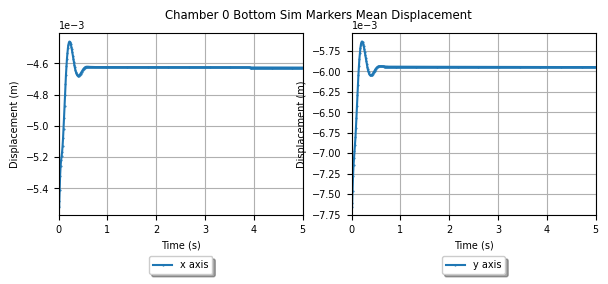

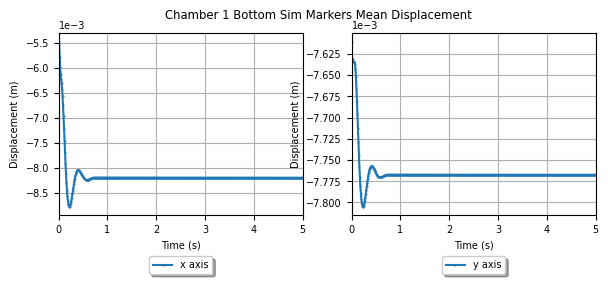

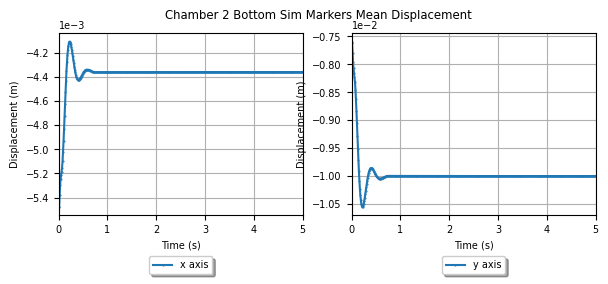

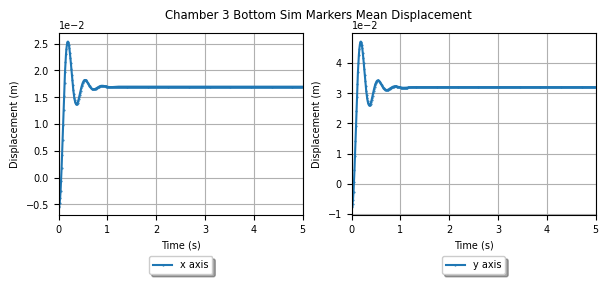

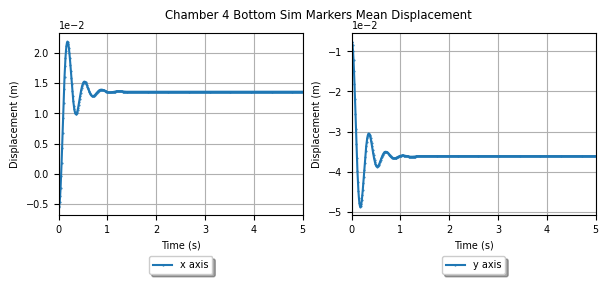

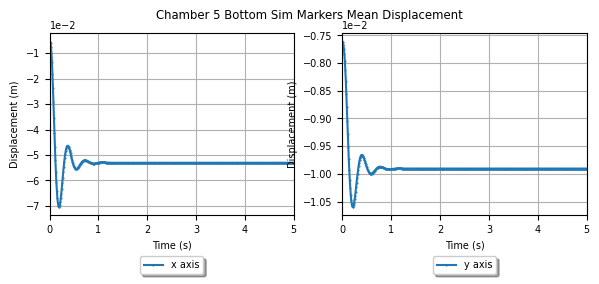

In [34]:
import matplotlib.pyplot as plt
import os
vis_1d_folder = f"1dplots/dofs_{sopra_env._dofs}"
os.makedirs(vis_1d_folder, exist_ok=True)
for chamber_i in range(6):
    simulated_markers_series = []
    real_markers_series = []
    sim_frames = len(qs_chambers[chamber_i])
    for frame_i in range(sim_frames):
        simulated_markers_series.append(sopra_env.return_simulated_markers(torch.from_numpy(qs_chambers[chamber_i][frame_i].reshape(-1, 3))).detach().numpy())
        real_markers_series.append(transformed_markers[chamber_i])
    figsize = (88*2*mm, 60*mm)
    fig, axs = plt.subplots(ncols=2, figsize=figsize)
    times = np.linspace(0, sim_frames * dt, sim_frames+1)[:-1]
    simulated_markers_series = np.array(simulated_markers_series)
    axs[0].plot(times, simulated_markers_series[:, -4:, 0].mean(1),linestyle='-', marker='o', markersize= 0.5,label=f"x axis")
    axs[1].plot(times, simulated_markers_series[:, -4:, 1].mean(1),linestyle='-', marker='o', markersize= 0.5,label=f"y axis")
    print(simulated_markers_series[:, :, 0].mean(1))
    for ax in axs.flat:
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Displacement (m)")
        ax.set_xlim(0, sim_frames * dt)
        ax.ticklabel_format(axis="y", style='sci', scilimits=(0,0))
        ax.grid()
        ax.set_axisbelow(True)
        ax.legend(loc='lower center', bbox_to_anchor=[0.5, -0.35], ncol=3, fancybox=True, shadow=True)
    #set title
    fig.suptitle(f"Chamber {chamber_i} Bottom Sim Markers Mean Displacement")
    fig.savefig(f"{vis_1d_folder}/sim_chamber_{chamber_i}.png", dpi=300, bbox_inches='tight', pad_inches=1*mm)


In [35]:
transformed_markers = base_q[:, :, 3:] @ R.T + t
transformed_markers.shape

(6, 500, 12, 3)

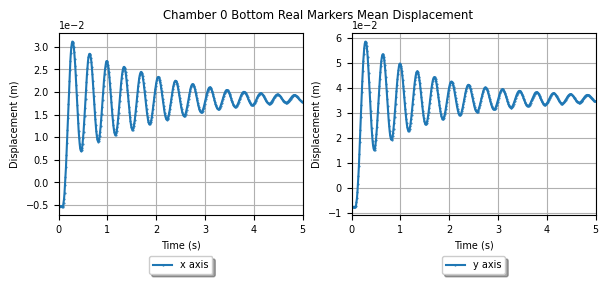

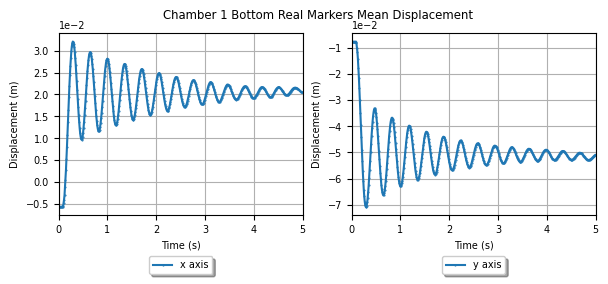

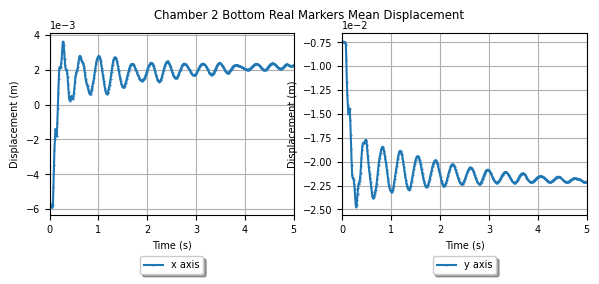

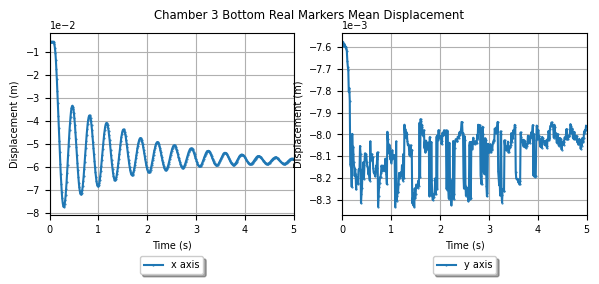

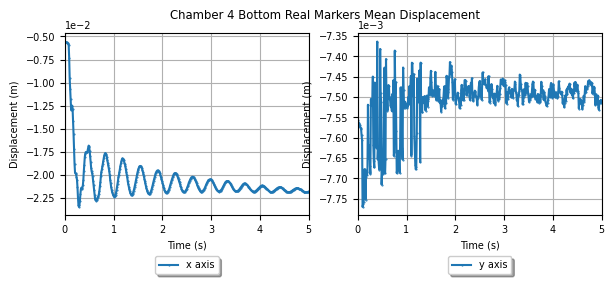

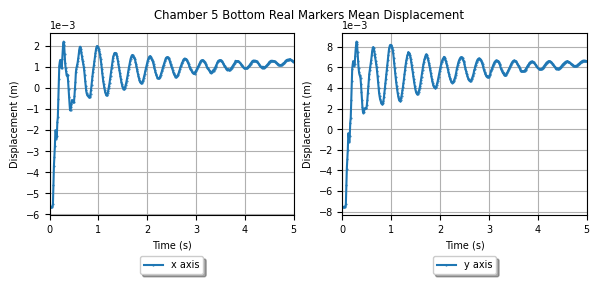

In [36]:
for chamber_i in range(6):
    fig, axs = plt.subplots(ncols=2, figsize=figsize)
    real_frames = transformed_markers.shape[1]
    times = np.linspace(0, real_frames * dt, real_frames+1)[:-1]
    axs[0].plot(times, transformed_markers[chamber_i][:, -4:, 0].mean(1),linestyle='-', marker='o', markersize=0.5,label=f"x axis")
    axs[1].plot(times, transformed_markers[chamber_i][:, -4:, 1].mean(1),linestyle='-', marker='o', markersize=0.5,label=f"y axis")
    for ax in axs.flat:
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Displacement (m)")
        ax.set_xlim(0, real_frames * dt)
        ax.ticklabel_format(axis="y", style='sci', scilimits=(0,0))
        ax.grid()
        ax.set_axisbelow(True)
        ax.legend(loc='lower center', bbox_to_anchor=[0.5, -0.35], ncol=3, fancybox=True, shadow=True)
        # ax.set_title(f"Chamber {chamber_i} Real Markers")
    fig.suptitle(f"Chamber {chamber_i} Bottom Real Markers Mean Displacement")
    fig.savefig(f"{vis_1d_folder}/real_chamber_{chamber_i}.png", dpi=300, bbox_inches='tight', pad_inches=1*mm)

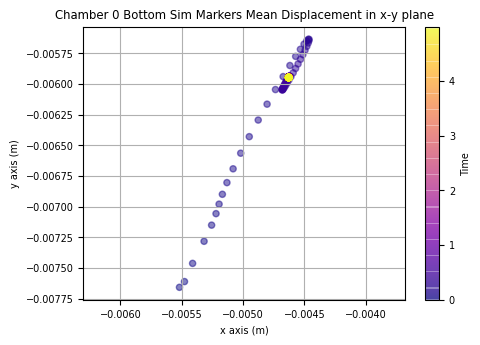

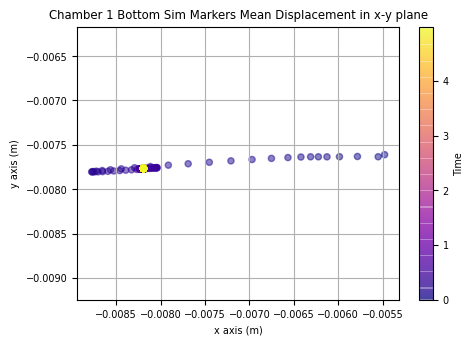

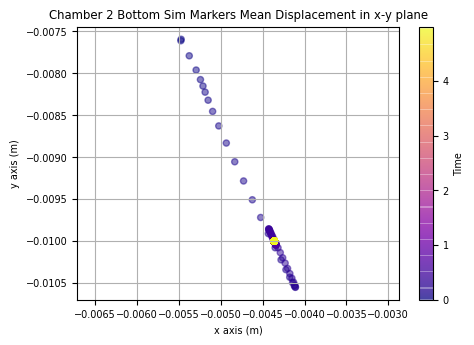

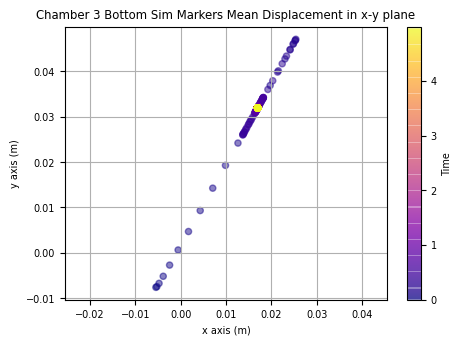

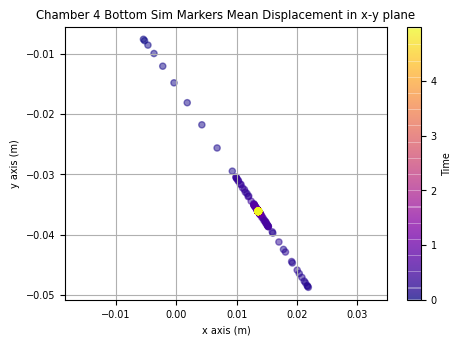

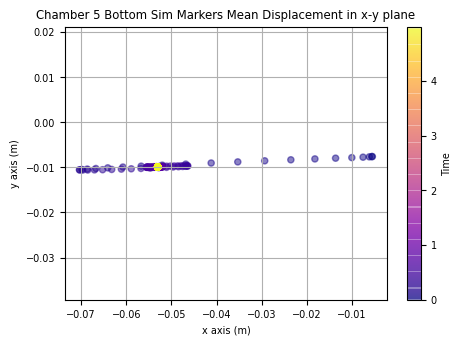

In [37]:
import matplotlib.pyplot as plt
import os
vis_1d_folder = f"2dplots/dofs_{sopra_env._dofs}"
qs_chambers = np.load(f"qs_chambers_{sopra_env._dofs}.npy", allow_pickle=True)
os.makedirs(vis_1d_folder, exist_ok=True)
mm = 1.5/25.4
for chamber_i in range(6):
    simulated_markers_series = []
    sim_frames = len(qs_chambers[chamber_i])
    times = np.linspace(0, sim_frames * dt, sim_frames+1)[:-1]
    for frame_i in range(sim_frames):
        simulated_markers_series.append(sopra_env.return_simulated_markers(torch.from_numpy(qs_chambers[chamber_i][frame_i].reshape(-1, 3))).detach().numpy())
    figsize = (88*mm, 60*mm)
    fig = plt.figure(figsize=figsize)
    simulated_markers_series = np.array(simulated_markers_series)
    plt.scatter(simulated_markers_series[:, -4:, 0].mean(1), simulated_markers_series[:, -4:, 1].mean(1), alpha= 0.5, c=times,cmap='plasma', s=20.0, label=f"Simulated")
    plt.xlabel("x axis (m)")
    plt.ylabel("y axis (m)")
    plt.colorbar(label='Time')
    plt.axis('equal') 
    plt.title(f"Chamber {chamber_i} Bottom Sim Markers Mean Displacement in x-y plane")
    plt.grid()


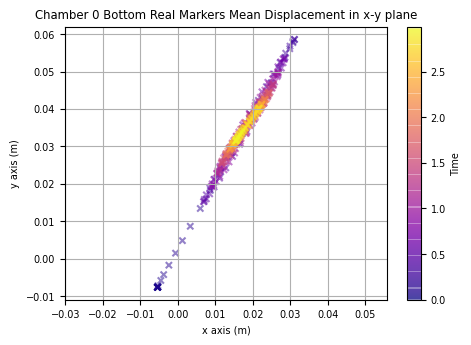

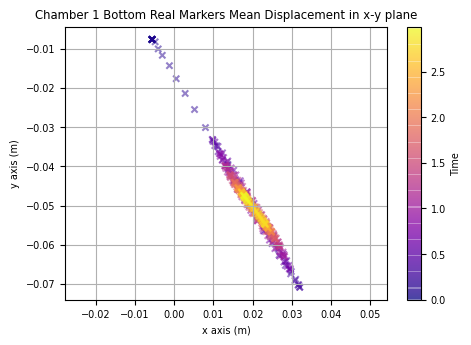

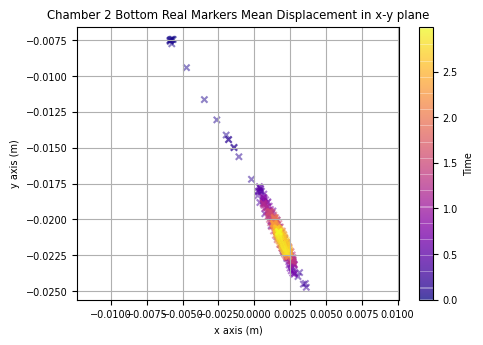

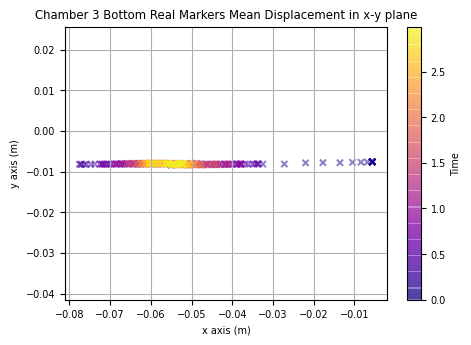

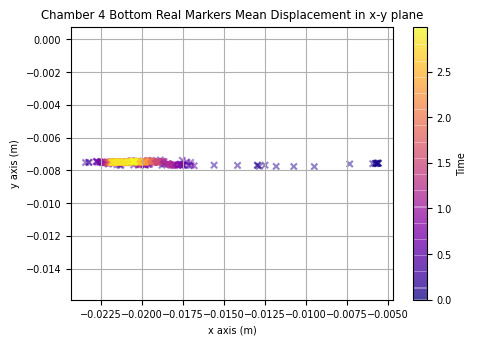

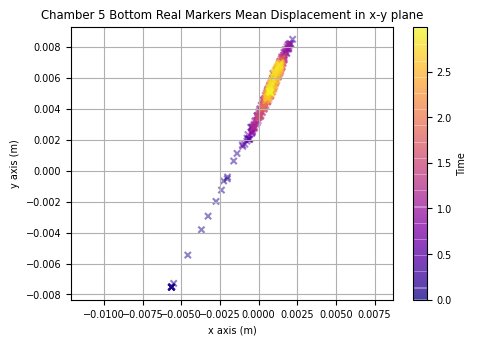

In [38]:
import matplotlib.pyplot as plt
import os
vis_1d_folder = f"2dplots/dofs_{sopra_env._dofs}"
qs_chambers = np.load(f"qs_chambers_{sopra_env._dofs}.npy", allow_pickle=True)
os.makedirs(vis_1d_folder, exist_ok=True)
transformed_markers = base_q[:, :, 3:] @ R.T + t
mm = 1.5/25.4
real_frames = 300
times = np.linspace(0, real_frames * dt, real_frames+1)[:-1]
for chamber_i in range(6):
    # real_frames = transformed_markers.shape[1]
    figsize = (88*mm, 60*mm)
    fig = plt.figure(figsize=figsize)
    plt.scatter(transformed_markers[chamber_i, :real_frames, -4:, 0].mean(1), transformed_markers[chamber_i, :real_frames, -4:, 1].mean(1), alpha= 0.5, s=20.0 , c=times, cmap='plasma', marker='x', label=f"Real")
    plt.xlabel("x axis (m)")
    plt.ylabel("y axis (m)")
    plt.axis('equal') 
    plt.title(f"Chamber {chamber_i} Bottom Real Markers Mean Displacement in x-y plane")
    plt.colorbar(label='Time')
    plt.grid()


sim chamber 0 -> real chamber 5
sim chamber 1 -> real chamber 4
sim chamber 2 -> real chamber 2
sim chamber 3 -> real chamber 0
sim chamber 4 -> real chamber 1
sim chamber 5 -> real chamber 3

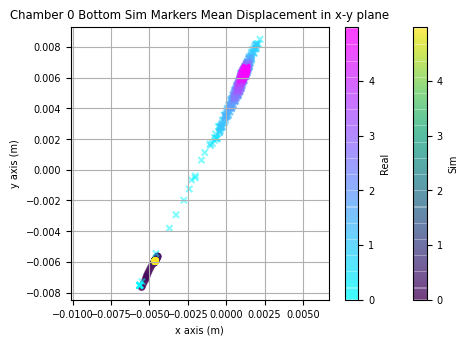

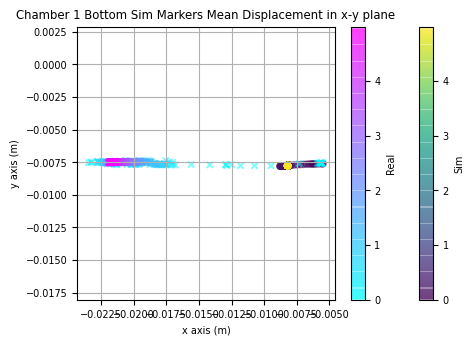

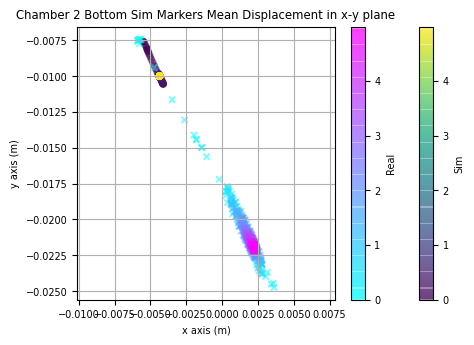

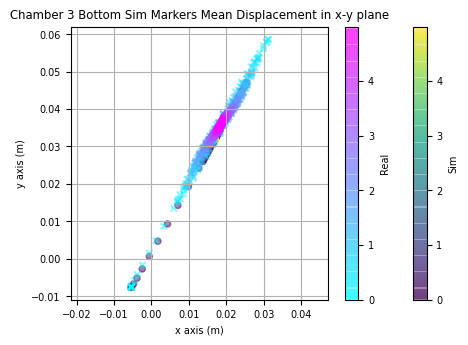

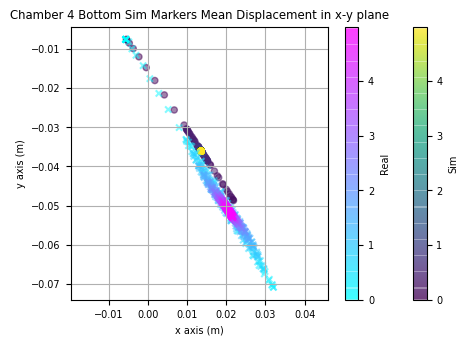

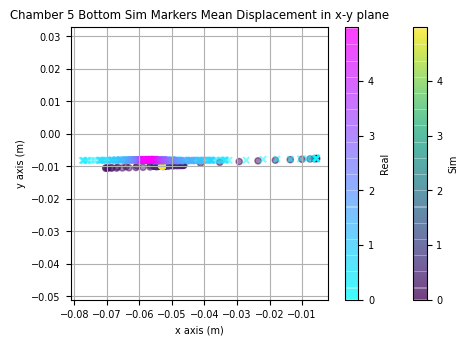

In [41]:
pairs = [[0,5], [1,4], [2,2], [3,0], [4,1], [5,3]]
vis_1d_folder = f"2dplots/dofs_{sopra_env._dofs}"
qs_chambers = np.load(f"qs_chambers_{sopra_env._dofs}.npy", allow_pickle=True)
os.makedirs(vis_1d_folder, exist_ok=True)
transformed_markers = base_q[:, :, 3:] @ R.T + t
mm = 1.5/25.4
for pair in pairs:
    sim_chamber, real_chamber = pair
    simulated_markers_series = []
    sim_frames = len(qs_chambers[sim_chamber])
    times = np.linspace(0, sim_frames * dt, sim_frames+1)[:-1]
    for frame_i in range(sim_frames):
        simulated_markers_series.append(sopra_env.return_simulated_markers(torch.from_numpy(qs_chambers[sim_chamber][frame_i].reshape(-1, 3))).detach().numpy())
    figsize = (88*mm, 60*mm)
    fig, ax = plt.subplots(figsize=figsize)
    simulated_markers_series = np.array(simulated_markers_series)
    scatter1 = ax.scatter(simulated_markers_series[:, -4:, 0].mean(1), simulated_markers_series[:, -4:, 1].mean(1), alpha= 0.5, c=times,cmap='viridis', s=20.0, label=f"Simulated")
    scatter2 = ax.scatter(transformed_markers[real_chamber, :sim_frames, -4:, 0].mean(1), transformed_markers[real_chamber, :sim_frames, -4:, 1].mean(1), alpha= 0.5, s=20.0 , c=times, cmap='cool', marker='x', label=f"Real")
    plt.colorbar(scatter1, ax=ax, label='Sim')
    plt.colorbar(scatter2, ax=ax, label='Real')
    plt.xlabel("x axis (m)")
    plt.ylabel("y axis (m)")
    plt.axis('equal') 
    plt.title(f"Chamber {sim_chamber} Bottom Sim Markers Mean Displacement in x-y plane")
    plt.grid()


Error is computed by 

$(\sum_i\|\text{Interpolated Markers}_i - \text{Transformed Real Markers}_i \|) / \sum_i\|\text{Real Marker Displacement}_i\|$

In [ ]:
import pandas as pd
# df = pd.DataFrame({"A": [1, 2, 3], "B": [1, 2, 3]}, index=['a', 'a', 'b'])  
pairs = [[0,5], [1,4], [2,2], [3,0], [4,1], [5,3]]
# print(df.to_markdown()) 
error_dict = {}
for i in range(len(pairs)):
    sim_chamber, real_chamber = pairs[i]
    displacements = transformed_markers[real_chamber, :] - transformed_markers[real_chamber, 0]
    error_dict[f"chamber_{real_chamber}"] = np.array(error_chamber[real_chamber]).sum()/np.linalg.norm(displacements)
df = pd.DataFrame(error_dict, index=['error'])
print(df.to_markdown())

|       |   chamber_5 |   chamber_4 |   chamber_2 |   chamber_0 |   chamber_1 |   chamber_3 |
|:------|------------:|------------:|------------:|------------:|------------:|------------:|
| error |   0.0502333 |   0.0382762 |   0.0233523 |  0.00171442 |  0.00444685 |  0.00835242 |
